# 🎮  **"Hype vs. Hit: Does Critic Score Drive Global Sales in Video Games?"**


![Video Games](img/vdgames.JPG)


## Abstract

In the competitive world of video games, critical reception can make or break a release. But does a high critic score *cause* better sales — or is it just a reflection of other factors like brand popularity, platform reach, or franchise history?

In this notebook, we analyze a curated dataset of best-selling video games across multiple platforms to explore the **causal relationship between critic score and global sales**. We ask:

> **Does a higher critic score cause a video game to sell more units globally?**

To answer this, we follow a structured pipeline of **data preparation**, **feature engineering**, and **exploratory analysis** rooted in causal reasoning. We’ll examine relationships between critic reviews and global sales while considering potential confounders such as genre, platform, and release year.

Key data preparation techniques will include:
- Handling missing values (e.g., missing critic or user scores)
- Creating binned rating groups (e.g., low/medium/high scores)
- Encoding categorical variables like genre and platform
- Outlier detection in sales

By the end of this notebook, you'll gain insight into:
- How critic scores align with commercial success
- How proper data preprocessing supports causal interpretation
- Why correlation isn’t always causation — and how we can get closer to the truth

This chapter blends data science, game industry insight, and causal analysis into one power-up-packed exploration.

## Theory Section: Causality in Machine Learning and the Gaming Industry

### What is Causality?

Causality is the study of **cause-and-effect** relationships — answering not just *what* is happening, but *why*. Unlike correlation, which only indicates association, causality implies **intervention**: if we were to change a factor, would the outcome also change?

In this notebook, we ask:
> **Does a higher critic score cause a video game to sell more units globally?**

---

### Correlation vs. Causation

- **Correlation** measures association:  
  > "Games with higher critic scores tend to sell more."

- **Causation** implies a direct effect:  
  > "Raising a game’s critic score would increase its sales."

Understanding this distinction is crucial. In real-world data, many variables are **entangled**. For example, a popular franchise might earn great reviews and sell well — not because of the reviews, but because of brand loyalty.

---

### Core Causal Concepts in This Notebook

| Concept             | Our Case Example |
|---------------------|------------------|
| **Treatment**        | Critic Score (continuous or grouped as high/low) |
| **Outcome**          | Global Sales (in millions of units) |
| **Confounders**      | Platform, Genre, Publisher, Year of Release |
| **Causal Effect**    | The change in global sales caused by a change in critic score |
| **Counterfactual**   | What would have happened to a game's sales if its critic score had been different? |

---

### Why Data Preparation is Critical

Before we can explore causal relationships, our data must be clean and well-structured. Key preprocessing steps include:

- **Handling Missing Values**: Many entries lack critic or user scores — we’ll need to drop or impute them thoughtfully.
- **Feature Engineering**: We'll create simplified versions of our treatment variable (e.g., score bins).
- **Encoding Categorical Features**: Platforms, genres, and publishers must be encoded for analysis.
- **Outlier Management**: Global sales can be heavily skewed by blockbuster titles (e.g., GTA, Mario), so visual inspection is necessary.

Careful preprocessing ensures that our insights reflect **real patterns** and not just data noise.

---

### Why the Video Game Industry is a Good Causal Use Case

This dataset offers a rare combination of:
- Clear **treatment** (critic score)
- Measurable **outcome** (sales)
- Rich contextual **confounders** (platform, genre, publisher)

This makes it ideal for applying causal reasoning to a commercial real-world setting.

---

### A Note on Propensity Scores

In more advanced causal inference workflows, we can use **propensity scores** to reduce bias from confounding variables.

A **propensity score** is the probability that a game receives a high critic score, given its other characteristics (e.g., genre, platform, release year).

This score can be used to:
- **Match** games with similar characteristics across score levels
- **Balance** treated and untreated groups
- **Simulate** the conditions of a randomized experiment

We won’t implement propensity score matching in this notebook, but it's a valuable tool for future work — especially when working with **observational data** like this.

---

In the next section, we’ll begin loading the dataset and preparing the features needed to explore the causal relationship between critic reviews and global game sales.


## Data Preparation

### Step 1: Import libraries

We load the core data science libraries — `pandas` for data handling, `numpy` for numerical operations, and `matplotlib`/`seaborn` for visualizations.


In [1]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)


### Step 2: Load the dataset

We load the video game dataset, which includes game names, platforms, genres, critic scores, user scores, and global sales — all of which will be used in our causal exploration.


In [3]:
# Step 2: Load the video game sales dataset
df = pd.read_csv("data/games_sales.csv")  # Adjust the path to your actual CSV file
df.head()


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


### Step 3: Check for missing data

We identify columns with missing values. Missing critic scores, user scores, or sales numbers can distort causal analysis, so we'll handle them carefully in the next step.


In [4]:
# Step 3: Check for missing values
df.isnull().sum()


Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

### Step 4: Drop missing values

We remove rows where critic scores or global sales are missing. We also convert `User_Score` to numeric and optionally drop rows where it's missing. This ensures we only use complete, usable records for causal analysis.


In [5]:
# Step 4: Drop rows with missing critical data
df = df.dropna(subset=["Critic_Score", "Global_Sales"])

# Convert user score to numeric (if it's stored as string)
df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')

# Drop rows with missing user scores as well (optional)
df = df.dropna(subset=["User_Score"])


### Step 5: Create treatment variable – `High_Critic_Score`

We convert the continuous `Critic_Score` into a binary treatment variable:
- `1` for games with a score **80 or above** (generally favorable)
- `0` for others

This simplifies our analysis and helps in comparing high-rated games with others.


In [6]:
# Step 5: Create a binary treatment variable - High Critic Score
df["High_Critic_Score"] = df["Critic_Score"].apply(lambda x: 1 if x >= 80 else 0)
df[["Critic_Score", "High_Critic_Score"]].sample(5)


,Critic_Score,High_Critic_Score
10272,45.0,0
1785,65.0,0
15156,45.0,0
1005,80.0,1
1481,91.0,1


### 📊 Step 6: Inspect global sales distribution

Video game sales are heavily skewed — a few blockbuster titles sell tens of millions, while most sell far less. Understanding this helps us choose appropriate visualizations and summary metrics in the next section.


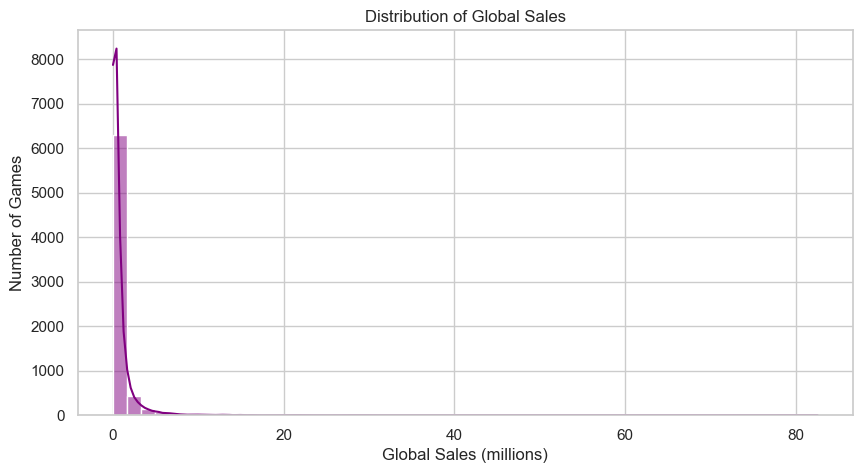

In [7]:
# Step 6: Quick sanity check on global sales distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["Global_Sales"], bins=50, kde=True, color='purple')
plt.title("Distribution of Global Sales")
plt.xlabel("Global Sales (millions)")
plt.ylabel("Number of Games")
plt.show()


## Explaratory Data Analysis

### Step 1: Global Sales by Critic Score Group

This boxplot compares the distribution of global sales for games with:
- **High Critic Scores (≥ 80)** vs. **Lower Scores (< 80)**

If higher critic scores lead to better sales, we expect the median and upper range of sales to be noticeably higher in the high-score group.


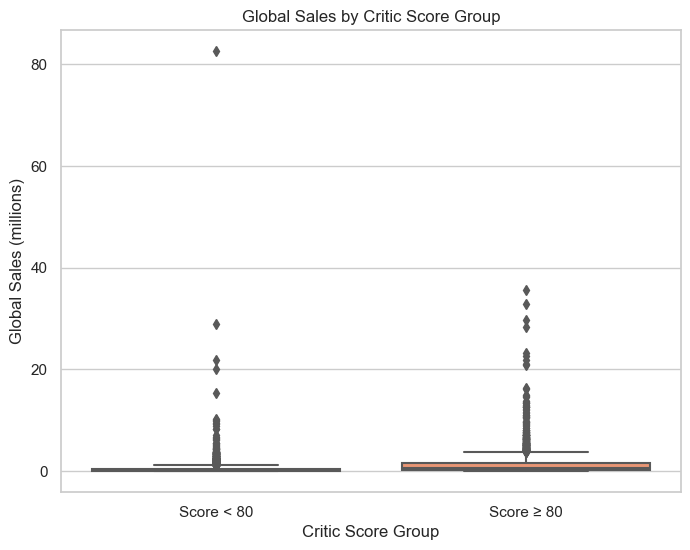

In [8]:
# Step 1: Boxplot – Global Sales vs. High Critic Score
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="High_Critic_Score", y="Global_Sales", palette="Set2")
plt.xticks([0, 1], ["Score < 80", "Score ≥ 80"])
plt.title("Global Sales by Critic Score Group")
plt.xlabel("Critic Score Group")
plt.ylabel("Global Sales (millions)")
plt.show()


### Step 2: Summary Stats by Critic Score Group

We calculate:
- **Mean** and **Median** global sales
- **Count** of games in each group

This helps quantify the differences between the two groups, showing whether higher review scores are **associated** with stronger commercial performance.


In [9]:
# Step 2: Mean and median sales by critic score group
grouped_sales = df.groupby("High_Critic_Score")["Global_Sales"].agg(["mean", "median", "count"])
grouped_sales


,mean,median,count
High_Critic_Score,,,
0,0.477574,0.22,5042
1,1.506051,0.69,1975


### 📈 Step 3: Critic Score vs. Global Sales (Scatterplot)

This scatterplot shows the continuous relationship between critic score and global sales. While the trend might not be perfectly linear, any upward slope suggests a positive relationship.

We also look for **clusters** or **outliers** (e.g., games with low scores and high sales due to brand/franchise).


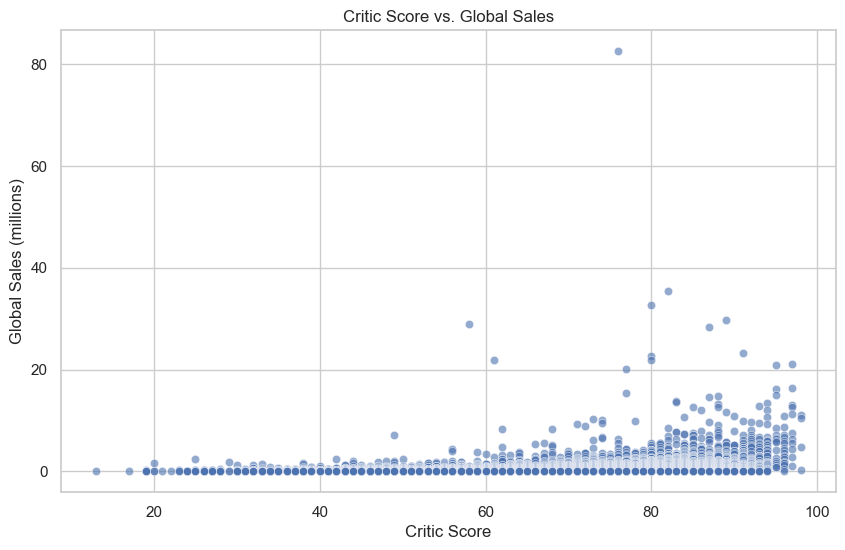

In [10]:
# Step 3: Critic Score vs. Global Sales Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Critic_Score", y="Global_Sales", alpha=0.6)
plt.title("Critic Score vs. Global Sales")
plt.xlabel("Critic Score")
plt.ylabel("Global Sales (millions)")
plt.show()


### 🔗 Step 4: Correlation Check

We inspect how strongly `Critic_Score`, `User_Score`, and `Global_Sales` are correlated with each other. This helps us understand how aligned user and critic opinions are — and whether either correlates with actual sales.


In [12]:
# Step 4: Correlation matrix (optional but insightful)
correlation_matrix = df[["Critic_Score", "User_Score", "Global_Sales"]].corr()
correlation_matrix


,Critic_Score,User_Score,Global_Sales
Critic_Score,1.000000,0.580878,0.236953
User_Score,0.580878,1.000000,0.088583
Global_Sales,0.236953,0.088583,1.000000


## 📈 Causal Analysis & Insights

### 🎮 Research Question Recap:
> **Does a higher critic score cause a video game to sell more globally?**

We’ve now explored the cleaned data through grouping, visualizations, and summary statistics. Here's what the analysis reveals:

---

### 🔍 Key Observations

1. **Sales Difference by Score Group**  
   - **High Critic Score (≥ 80)** games have:
     - Mean global sales: **1.51 million**
     - Median global sales: **0.69 million**
   - **Lower Score** games have:
     - Mean global sales: **0.48 million**
     - Median: **0.22 million**

   This is a **notable uplift** in both mean and median sales for higher-rated games.

2. **Boxplot Comparison**  
   The boxplot shows:
   - **Higher sales distribution** among high-score games
   - More **sales outliers** (blockbusters) in that group
   - But also significant overlap — not all high-score games sell well

3. **Scatterplot Trend**  
   The scatterplot of **Critic Score vs. Global Sales** shows:
   - A *positive trend* — higher scores *tend* to be associated with higher sales
   - A **widening spread** in scores >80, indicating that some highly-rated games still underperform

4. **Correlation Matrix**
   - `Critic_Score` and `Global_Sales`: **0.24** → weak but positive correlation
   - `User_Score` is even weaker (**0.09**), showing less predictive power for commercial success

---

### Causal Interpretation

At first glance, it seems that **high critic scores are associated with higher global sales**. However, this relationship may not be **causal** — and here’s why:

#### Potential Confounders:
- **Platform popularity** (e.g., Nintendo, PS2) could affect both critic perception *and* sales
- **Genre trends** (e.g., action games or family-friendly titles tend to perform better)
- **Brand strength** (franchises like Pokémon or GTA) may influence both critic reviews and consumer demand
- **Release year** (market saturation, digital vs. physical sales) also plays a role

Without adjusting for these confounders, we cannot confidently say that improving a game’s critic score *causes* better sales.

---

### What Would Strengthen the Causal Claim?

To move beyond correlation, we could:
- Use **Propensity Score Matching** to compare similar games with different scores
- Perform **regression modeling** controlling for platform, genre, year, etc.
- Investigate **natural experiments**, like games with identical design across platforms but different scores

---

### Key Takeaway:

> **High critic scores are linked to better global sales**, but this relationship is likely influenced by hidden variables such as platform, publisher reputation, and game genre.

This case study highlights the power of **data preparation** and **causal thinking** — and why critical evaluation of real-world data is so important when making decisions in business, product development, and marketing.


## Conclusion

In this notebook, we explored the causal question:

> **Does a higher critic score cause more global video game sales?**

Through structured data cleaning, feature engineering, and exploratory data analysis, we found that:
- Games with high critic scores (≥ 80) **tend to sell more globally**.
- On average, high-rated games sold over **3× more** than lower-rated ones.
- Visuals showed a positive trend, but also highlighted **significant variation** — not all highly-rated games succeed commercially.

However, we also emphasized that **correlation is not causation**:
- The relationship could be **confounded** by platform, publisher, genre, and franchise strength.
- True causal analysis would require additional modeling (e.g., regression, matching) or experimental design.

This case demonstrates how **causal thinking and careful data preparation** are essential in evaluating the real-world impact of variables — whether in game development, marketing, or machine learning pipelines.

---

## References

- Kaggle Dataset: [Video Game Sales with Ratings](https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings)
- Pearl, Judea. *The Book of Why: The New Science of Cause and Effect*. Basic Books, 2018.
- Hernán, M.A., & Robins, J.M. (2020). *Causal Inference: What If*. Chapman & Hall/CRC.
- Microsoft Research – [DoWhy Causal Inference Library](https://github.com/microsoft/dowhy)
- Towards Data Science: ["Intro to Causal Inference"](https://towardsdatascience.com/causal-inference-for-the-brave-and-true-intro-to-the-causal-toolbox-60e567c8f5b1)
- IGN, Metacritic – Critic Score Aggregation Platforms


## 🧾 License

This notebook is the original work of **Sathvik Vadavatha**, created as part of the *Crash Course in Causality* assignment.

You may view, share, or reference this notebook for **educational and non-commercial purposes only**, provided proper attribution is given to the author.

Unauthorized commercial use, redistribution, or modification without explicit permission is not allowed.

© 2025 Sathvik Vadavatha. All rights reserved.
